# Project: create an image classifier
Author: Yu Ling Wu (December 2021)

# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Additional imports
import pandas as pd
from torchvision import models

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

To select the optimal normalization, the mean and standard deviation first need to be determined. This was also discussed in https://knowledge.udacity.com/questions/740251.

According to https://www.cs.toronto.edu/~kriz/cifar.html the `CIFAR10` dataset consists of 60000 images, with 50000 images in the training set and 10000 images in the test set. To have the same number of images in each batch, the batch_size is set to a number through which the number of images is dividable.

In [3]:
# Create training set to determine the mean and std required to optimize the normalization
# First only transform to tensor
exploretrain_data = torchvision.datasets.CIFAR10('./check/train', train = True, download= True, transform= transforms.ToTensor())

# Create a dataloader to explore the train dataset
exploretrainloader = torch.utils.data.DataLoader(exploretrain_data, batch_size= 50, shuffle= True)

Files already downloaded and verified


In [4]:
# Import test data for printing, i.e. no transforms
exploretest_data = torchvision.datasets.CIFAR10('./check/test', train = False, download= True, transform= transforms.ToTensor())

# Create a dataloader to explore the test dataset
exploretestloader = torch.utils.data.DataLoader(exploretest_data, batch_size= 50, shuffle= True)

Files already downloaded and verified


In [5]:
# Calculate the mean and standard deviation to determine the Normalization
exploretrain_images = torch.stack([image for image, _ in exploretrain_data], dim =3)
mean, std = exploretrain_images.view(3, -1).mean(dim=1), exploretrain_images.view(3, -1).std(dim=1)
print(mean, std)

tensor([ 0.3277,  0.3277,  0.3277]) tensor([ 0.2470,  0.2435,  0.2616])


In [6]:
# Size images in the explore train loader, i.e. without any transformations
image, label = next(iter(exploretrainloader))
image.shape

torch.Size([50, 3, 32, 32])

In [7]:
# Size images in the explore test loader, i.e. without any transformations
image, label = next(iter(exploretestloader))
image.shape

torch.Size([50, 3, 32, 32])

The training and test images have 3 color channels and are 32 by 32 pixels. 

I will use rotation, cropping and horizontal flipping as augmentation techniques. I will crop the images to something smaller than the original and select to crop them to 28 x 28 pixels. With the 3 color channels, this will result in 3 x 28 x 28= 2352 features.

In [8]:
# Define transforms
train_transform = transforms.Compose([transforms.RandomRotation(30),
                               transforms.RandomResizedCrop(28),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize([ 0.3277,  0.3277,  0.3277],
                                                   [ 0.2470,  0.2435,  0.2616])]) 
test_transform = transforms.Compose([transforms.Resize(30),
                               transforms.CenterCrop(28),
                               transforms.ToTensor(),
                               transforms.Normalize([ 0.3277,  0.3277,  0.3277],
                                                   [ 0.2470,  0.2435,  0.2616])])

# Create training set and define training dataloader
train_data = torchvision.datasets.CIFAR10('./data/train', train = True, download= True, transform= train_transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size= 50, shuffle= True)

# Create test set and define test dataloader
test_data = torchvision.datasets.CIFAR10('./data/test', train = False, download= True, transform= test_transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size= 50, shuffle= True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [9]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

As mentioned above, the training and testing images have 3 color channels and are 32 by 32 pixels before doing any transformations.

truck


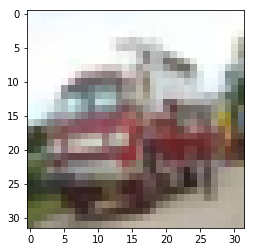

dog


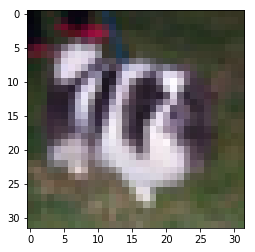

car


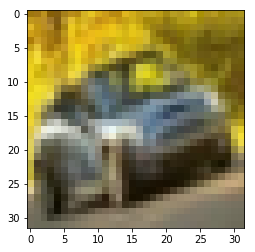

truck


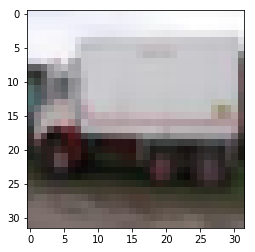

car


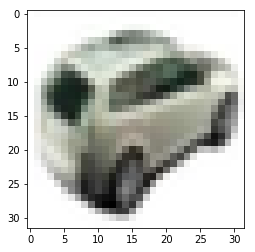

In [10]:
# Print some images from the training dataset without any transformations
show5(exploretrainloader)

Print one of the images from the test set. 

frog


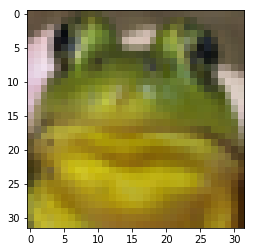

In [11]:
image, label = next(iter(exploretestloader))
print(classes[label[0]])
plt.imshow(np.rot90(image[0].numpy().T, k=3))
plt.show()

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

I will use a model with 3 hidden layers, with 1176, 588 and 294 units respectively. To reduce overfitting and thus increase generalization, I will use drop-out.

In [12]:
image, label = next(iter(trainloader))
image[0].shape

torch.Size([3, 28, 28])

In [13]:
image.view(50, -1).shape

torch.Size([50, 2352])

In [14]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(2352, 1176)
        self.hidden2 = nn.Linear(1176, 588)
        self.hidden3 = nn.Linear(588, 294)
        self.hidden4 = nn.Linear(294, 147)
        self.out = nn.Linear(147, 10)
        
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        # make into the right shape
        x = x.view(50, -1)
        
        # with dropout
        x = self.dropout(F.relu(self.hidden1(x)))
        x = self.dropout(F.relu(self.hidden2(x)))
        x = self.dropout(F.relu(self.hidden3(x)))
        x = self.dropout(F.relu(self.hidden4(x)))
        # output therefore without dropout
        x = F.log_softmax(self.out(x), dim=1)
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [15]:
# Instantiate the model, define loss function and optimizer
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.0005)

Adam was chosen rather than SGD because it uses momentum, which can help passing a local minimum and going towards a lower mimimum. In addition it also adjusts the learning rate, which prevents that close to a minimum you pass the minimum and never go into it.

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [16]:
# Move model to GPU if available
if torch.cuda.is_available(): model = model.cuda()

epochs = 20
print_every = 250

# Make empty list to store the train and test losses
train_losses, test_losses, accuracy_list = [], [], []

for e in range(epochs):
    print('epoch = ', e+1)
    step = 0
    training_loss = 0
    for images, labels in trainloader:
        # Move data to GPU if available
        if torch.cuda.is_available(): images= images.cuda()
        if torch.cuda.is_available(): labels = labels.cuda()
        # Clear the gradients
        optimizer.zero_grad()
        # Forward pass calculating log probabilities
        log_ps = model.forward(images)
        # Calculate the loss
        loss = criterion(log_ps, labels)
        # Backward step to calculate gradients
        loss.backward()
        # Update the weights
        optimizer.step()
        
        step += 1
        training_loss += loss.item()
    
        if step % print_every == 0:
            test_loss = 0
            accuracy = 0

            # Turn off gradients for validation
            with torch.no_grad():
                # Set model to evaluation mode, i.e. no dropout
                model.eval()
                for images, labels in testloader:
                    # Move data to GPU if available
                    if torch.cuda.is_available(): images= images.cuda()
                    if torch.cuda.is_available(): labels = labels.cuda()
                    # Determine the log probabilities
                    log_ps = model.forward(images)

                    # Add the loss to the test_loss
                    test_loss += criterion(log_ps, labels)

                    # Determine the probabilties
                    ps = torch.exp(log_ps)
                    # Determine what the top class
                    top_ps, top_class = ps.topk(1, dim=1)
                    # Determine if top class equals the label
                    equals = top_class == labels.view(*top_class.shape)
                    # Calculate the accuracy
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

                print(f"Epoch {e+1}/{epochs}.. "
                  f"Step: {step}.."
                  f"Train loss: {training_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")

                # Losses
                train_losses.append(training_loss/print_every)
                test_losses.append(test_loss/len(testloader))
                accuracy_list.append(accuracy.item()/len(testloader))
                
                training_loss = 0
                # Set model back to training mode
                model.train()  

epoch =  1
Epoch 1/20.. Step: 250..Train loss: 2.113.. Test loss: 1.935.. Test accuracy: 0.292
Epoch 1/20.. Step: 500..Train loss: 2.026.. Test loss: 1.890.. Test accuracy: 0.319
Epoch 1/20.. Step: 750..Train loss: 1.992.. Test loss: 1.859.. Test accuracy: 0.360
Epoch 1/20.. Step: 1000..Train loss: 1.975.. Test loss: 1.814.. Test accuracy: 0.353
epoch =  2
Epoch 2/20.. Step: 250..Train loss: 1.967.. Test loss: 1.792.. Test accuracy: 0.364
Epoch 2/20.. Step: 500..Train loss: 1.950.. Test loss: 1.746.. Test accuracy: 0.379
Epoch 2/20.. Step: 750..Train loss: 1.940.. Test loss: 1.752.. Test accuracy: 0.397
Epoch 2/20.. Step: 1000..Train loss: 1.924.. Test loss: 1.715.. Test accuracy: 0.402
epoch =  3
Epoch 3/20.. Step: 250..Train loss: 1.913.. Test loss: 1.684.. Test accuracy: 0.402
Epoch 3/20.. Step: 500..Train loss: 1.905.. Test loss: 1.738.. Test accuracy: 0.385
Epoch 3/20.. Step: 750..Train loss: 1.894.. Test loss: 1.698.. Test accuracy: 0.398
Epoch 3/20.. Step: 1000..Train loss: 1.89

In [17]:
# Make dataframe with losses and accuracy of the model
df_model1 = pd.DataFrame(list(zip(train_losses, test_losses, accuracy_list)),
                        columns= ['train_losses', 'test_losses', 'accuracy_list'])

# Export as csv-file to allow importing it later
df_model1.to_csv('metrics_model1.csv', index= False)

Plot the training loss (and validation loss/accuracy, if recorded).

In [18]:
# Uncomment to import the metrics of model1 if require
# df_model1= pd.read_csv('metrics_model1.csv')
# for i in range(len(df_model1)):
#     df_model1['test_losses'][i] = float(df_model1['test_losses'][i][7:13])
# df_model1

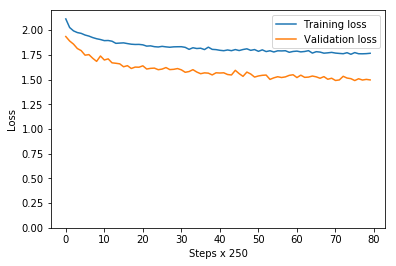

In [19]:
# Plot training and test losses
plt.plot(df_model1['train_losses'], label= "Training loss")
plt.plot(df_model1['test_losses'], label= "Validation loss")
plt.ylabel('Loss')
plt.xlabel(f'Steps x {print_every}')
plt.ylim(0, 2.2)
plt.legend();

The validation loss is not decreasing much more with increasing number of steps, therefore the training was stopped. The validation loss is also not increasing yet, therefore the network is not significantly overfitting yet.

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

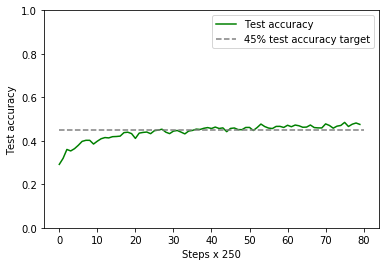

In [21]:
# Plot the test accuracy
plt.plot(df_model1['accuracy_list'], label= "Test accuracy", color= 'green')
plt.plot([0, len(df_model1)], [0.45, 0.45], label = '45% test accuracy target', linestyle= '--', color= 'grey')
plt.ylabel('Test accuracy')
plt.xlabel(f'Steps x {print_every}')
plt.legend()
plt.ylim(0, 1);

Strictly speaking, this model reached the target of 45% accuracy, but only just. It is quite likely that a more sophisticated model could do better. Therefore, I will also investigate the accuracy that could be reached with one of the torchvision networks.

## Saving your model
Using `torch.save`, save your model for future loading.

In [22]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Classifier(
  (hidden1): Linear(in_features=2352, out_features=1176, bias=True)
  (hidden2): Linear(in_features=1176, out_features=588, bias=True)
  (hidden3): Linear(in_features=588, out_features=294, bias=True)
  (hidden4): Linear(in_features=294, out_features=147, bias=True)
  (out): Linear(in_features=147, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
) 

The state dict keys: 

 odict_keys(['hidden1.weight', 'hidden1.bias', 'hidden2.weight', 'hidden2.bias', 'hidden3.weight', 'hidden3.bias', 'hidden4.weight', 'hidden4.bias', 'out.weight', 'out.bias'])


In [23]:
# Save the model
torch.save(model.state_dict(), 'checkpoint_model1.pth')

## Loading the saved model

In [ ]:
# Uncomment if required
# state_dict = torch.load('checkpoint_model1.pth')
# print(state_dict.keys())

In [ ]:
# Uncomment if required
# model1 = Classifier()
# model1.load_state_dict(state_dict)

## Retry with torchvision model Densenet-121
The current model passed the target of 45% accuracy, but it doesn't beat Detectocorp's model. Therefore, I will try an existing network from torchvision. Based on the top-1 and top-5 error the ResNet and Densenet models seemed an obvious choice. A resource ([link](https://www.youtube.com/watch?v=cPCeGMwrD9c)) claimed a better performence of Densenet compared to ResNet and therefore, I selected a Densenet, the simplest one, for this project. The model, like all the torchvision pre-trained models, expect input images normalized using mean= [0.485, 0.456, 0.406] and std= [0.229, 0.224, 0.225]. The images are expected to be 3-channel RGB images of shape (3 x H x W), where H and W are at least 224 ([torchvision.models](https://pytorch.org/docs/0.3.0/torchvision/models.html#id5)).

### Load data for model based on Densenet-121

In [4]:
# Define transforms
train_transform = transforms.Compose([transforms.RandomRotation(30),
                               transforms.RandomResizedCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])]) 
test_transform = transforms.Compose([transforms.Resize(255),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])

# Create training set and define training dataloader
train_data = torchvision.datasets.CIFAR10('./dataDense/train', train = True, download= True, transform= train_transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size= 50, shuffle= True)

# Create test set and define test dataloader
test_data = torchvision.datasets.CIFAR10('./dataDense/test', train = False, download= True, transform= test_transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size= 50, shuffle= True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [25]:
# Size images in the train loader
image, label = next(iter(trainloader))
image.shape

torch.Size([50, 3, 224, 224])

In [26]:
# Size images in the test loader
image, label = next(iter(testloader))
image.shape

torch.Size([50, 3, 224, 224])

In [13]:
# Import the pretrained Densenet121
model2 = models.densenet121(pretrained= True)
model2

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

This model contains two parts: 1) the features and 2) the classifer. The feature part will be kept as it and therefore the parameters will be frozen in order not to backpropagate through them. The classifier part was trained on the ImageNet dataset, so won't work for the CIFAR10 dataset. Therefore, a new classifier will be defined. I will give that classifier one hidden layer.

In [14]:
# Freeze parameters of features part
for param in model2.parameters():
    param.requires_grad = False

In [15]:
# Define classifier for the pretrained model
classifier = nn.Sequential(nn.Linear(1024, 512),
                          nn.ReLU(),
                          nn.Linear(512, 10),
                          nn.LogSoftmax(dim=1))

In [16]:
# Replace the newly defined classifier to the pretrained model
model2.classifier = classifier
model2

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [17]:
# Define optimizer and criterion
optimizer = optim.Adam(model2.classifier.parameters(), lr= 0.0005)
criterion = nn.NLLLoss()

### Run the adapted Densenet neural network

In [ ]:
# Move model to GPU if available
if torch.cuda.is_available(): model2 = model2.cuda()

epochs = 5
print_every = 250

# Make empty list to store the train and test losses
train_losses2, test_losses2, accuracy_list2 = [], [], []

for e in range(epochs):
    print('epoch = ', e+1)
    step = 0
    training_loss = 0
    for images, labels in trainloader:
        # Move data to GPU if available
        if torch.cuda.is_available(): images= images.cuda()
        if torch.cuda.is_available(): labels = labels.cuda()
        # Clear the gradients
        optimizer.zero_grad()
        # Forward pass calculating log probabilities
        log_ps = model2.forward(images)
        # Calculate the loss
        loss = criterion(log_ps, labels)
        # Backward step to calculate gradients
        loss.backward()
        # Update the weights
        optimizer.step()
        
        step += 1
        training_loss += loss.item()
    
        if step % print_every == 0:
            test_loss = 0
            accuracy = 0

            # Turn off gradients for validation
            with torch.no_grad():
                # Set model to evaluation mode, i.e. no dropout
                model2.eval()
                for images, labels in testloader:
                    # Move data to GPU if available
                    if torch.cuda.is_available(): images= images.cuda()
                    if torch.cuda.is_available(): labels = labels.cuda()
                    # Determine the log probabilities
                    log_ps = model2.forward(images)

                    # Add the loss to the test_loss
                    test_loss += criterion(log_ps, labels)

                    # Determine the probabilties
                    ps = torch.exp(log_ps)
                    # Determine what the top class
                    top_ps, top_class = ps.topk(1, dim=1)
                    # Determine if top class equals the label
                    equals = top_class == labels.view(*top_class.shape)
                    # Calculate the accuracy
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

                print(f"Epoch {e+1}/{epochs}.. "
                  f"Step: {step}.."
                  f"Train loss: {training_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")

                # Losses
                train_losses2.append(training_loss/print_every)
                test_losses2.append(test_loss/len(testloader))
                accuracy_list2.append(accuracy.item()/len(testloader))
                
                training_loss = 0
                # Set model back to training mode
                model2.train() 

epoch =  1
Epoch 1/5.. Step: 250..Train loss: 1.739.. Test loss: 1.086.. Test accuracy: 0.645
Epoch 1/5.. Step: 500..Train loss: 1.491.. Test loss: 0.969.. Test accuracy: 0.680
Epoch 1/5.. Step: 750..Train loss: 1.436.. Test loss: 0.926.. Test accuracy: 0.682
Epoch 1/5.. Step: 1000..Train loss: 1.425.. Test loss: 0.908.. Test accuracy: 0.696
epoch =  2
Epoch 2/5.. Step: 250..Train loss: 1.393.. Test loss: 0.912.. Test accuracy: 0.684
Epoch 2/5.. Step: 500..Train loss: 1.386.. Test loss: 0.862.. Test accuracy: 0.707
Epoch 2/5.. Step: 750..Train loss: 1.376.. Test loss: 0.834.. Test accuracy: 0.712
Epoch 2/5.. Step: 1000..Train loss: 1.380.. Test loss: 0.851.. Test accuracy: 0.713
epoch =  3
Epoch 3/5.. Step: 250..Train loss: 1.358.. Test loss: 0.852.. Test accuracy: 0.708
Epoch 3/5.. Step: 500..Train loss: 1.364.. Test loss: 0.846.. Test accuracy: 0.701
Epoch 3/5.. Step: 750..Train loss: 1.341.. Test loss: 0.791.. Test accuracy: 0.730
Epoch 3/5.. Step: 1000..Train loss: 1.335.. Test los

### Save the train and test losses

In [33]:
# Make dataframe with losses and accuracy of the model
df_model2 = pd.DataFrame(list(zip(train_losses2, test_losses2, accuracy_list2)),
                        columns= ['train_losses', 'test_losses', 'accuracy_list'])

# Export as csv-file to allow importing it later
df_model2.to_csv('metrics_model2.csv', index= False)

### Plot the training and validation losses and inspect the test accuracy

Plot the training and validation loss.

In [4]:
# Uncomment to import the metrics of model1 if require
# df_model2= pd.read_csv('metrics_model2.csv')
# for i in range(len(df_model2)):
#     df_model2['test_losses'][i] = float(df_model2['test_losses'][i][7:13])
# df_model2

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,train_losses,test_losses,accuracy_list
0,1.713478,1.1405,0.6198
1,1.494727,1.0282,0.6510
2,1.441653,0.9121,0.7023
3,1.433198,0.9311,0.6902
4,1.400044,0.8785,0.6964
5,1.399350,0.8688,0.7041
6,1.378959,0.872,0.6996
7,1.363943,0.8103,0.7219
8,1.350488,0.8392,0.7057
9,1.369415,0.8815,0.6871


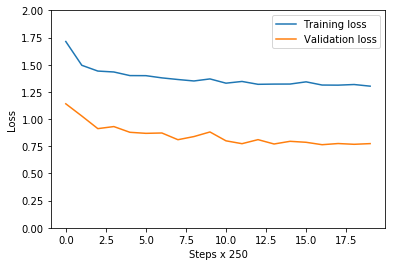

In [35]:
# Plot training and test losses
plt.plot(df_model2['train_losses'], label= "Training loss")
plt.plot(df_model2['test_losses'], label= "Validation loss")
plt.ylabel('Loss')
plt.xlabel(f'Steps x 250')
plt.ylim(0, 2)
plt.legend();

The validation loss is slowly approaching a constant value, suggesting that further training would not significantly improve the accuracy. 

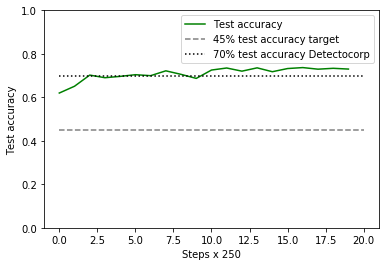

In [10]:
# Plot the test accuracy
plt.plot(df_model2['accuracy_list'], label= "Test accuracy", color= 'green')
plt.plot([0, len(df_model2)], [0.45, 0.45], label = '45% test accuracy target', linestyle= '--', color= 'grey')
plt.plot([0, len(df_model2)], [0.70, 0.70], label = '70% test accuracy Detectocorp', linestyle= 'dotted', color= 'black')
plt.ylabel('Test accuracy')
plt.xlabel(f'Steps x 250')
plt.legend()
plt.ylim(0, 1);

### Saving the adapted Densenet neural network

In [37]:
print("Our model: \n\n", model2, '\n')
print("The state dict keys: \n\n", model2.state_dict().keys())

Our model: 

 DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1

In [38]:
torch.save(model2.state_dict(), 'checkpoint_model2.pth')

### Loading the saved adapted Densenet neural network

In [ ]:
# Uncomment if required
# state_dict2 = torch.load('checkpoint_model2.pth')
# print(state_dict2.keys())

In [ ]:
# Uncomment if required
# model2.load_state_dict(state_dict2)

In [ ]:
# Uncomment if required
# Only predict
# with torch.no_grad():
#     model2.eval()
#     for images, labels in testloader:
#         if torch.cuda.is_available(): images = images.cuda()
#         if torch.cuda.is_available(): labels = labels.cuda()
#         log_ps = model2.forward(images)
#         ps = torch.exp(log_ps)
#         top_ps, top_class = ps.topk(1, dim=1)
#         equals = top_class == labels.view(*top_class.shape)
#         accuracy = torch.mean(equals.type(torch.FloatTensor))
#     print(f"Test accuracy: {accuracy/len(testloader):.3f}")

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

My recommendation is to build our own neural network, rather than buying the one from Detectocorp.

The simple model that I made from scratch reached 48% accuracy. I reached it by increasing the number of hidden layers and optimizing the learning rate. It exceeds the 45% accuracy target, but reaches significantly lower accuracy than the 70% accuracy from Detectocorp. The pre-trained DenseNet121 network combined with a classifier to make it applicable to the CIFAR-10 dataset reached a 73% accuracy. It exceeds the Detectocorp accuracy. The achieved 73% accuracy is lower than the advanced solutions in literature. 

Using the DenseNet121 the largest contributor to achieving the 73% accuracy. Based on the top-1 and top-5 error of the torchvision models, I initially thought of using a Resnet network, but a brief search in literature suggested ([link](https://www.youtube.com/watch?v=cPCeGMwrD9c)) that DenseNet had a better performance. Even with only one hidden layer in the classifier, this high accuracy was achieved. 

Whether the achieved accuracy needs to be improved depends on whether the current accuracy is sufficient to develop a self-driving car or that there are too many incidents/accidents because of it. Possibilities to improve the accuracy are:
- adjust the network, e.g. increase the number of hidden layers
- optimize the learning rate further
- optim.Adam was used, which already uses momentum, but maybe the specifics of the momentum can be improved
- add random initialization can be used to increase the probability to find the global or a deeper local minimum
- use a more complex (Densenet) pre-trained model
- add additional or adjust existing transformations on the training images

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).